# Predicting Missing Fitbit Data

## Summary of Findings

---
## Project Plan

### Goals
 - Predict missing values from the data set using clustering
 - Derive insights on "Armstrong", the person from whom the fitness data was generated

### Hypotheses
 - There are patterns on Armstrong's daily activities.
 - Armstrong's fitness activity is affected by the month/season of the year.

### Data Science Skills Used
 - Data prep and cleaning
 - Time Series Analysis
 - Visualization
 - Modeling using Parametric Methods
 - Modeling using the Prophet algorithm
 - Evaluation of Models

---
## Data Dictionary

---
## Notes on the Fitbit Data:

We are given eight .csv files that hold monthly data of an individual, whom we elect to call "Armstrong". Before we begin wrangling the data, we peruse all the files and made initial notes as follows:

1. The "missing" data is from 6/27/2018 - 7/6/2018 on the following variables:
  - Steps
  - Distance
  - Floors
  - Lightly Active in Minutes
  - Fairly Active in Minutes
  - Very Active in Minutes
2. Food/ Food log data is almost empty. There are only 1 record available in May-June data, and 7 records in the October-November data.
3. The data range covers April 26, 2018 to December 6, 2018.

### Packages

In [1]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# ignore warnings
import warnings
warnings.filterwarnings("ignore")
import acquire
#import prepare
#import summarize
#from acquire import get_store_data
#from prepare import prep_store_data, split_store_data
# from summarize import df_summary

## I. Acquire and Preprocess

We manipulated the individual csv files from Excel, and decided to create a single .csv file as the size of the data is manageable. We only wanted the activity data, and not the food/food log data which barely contain any data.

`act.csv` is the csv file that integrates all relevant activitiy data from the eight .csv files provided.

The `acquire` function from the acquire.py module produces a data frame out of `act.csv` and renames the columns for efficiency.

In [3]:
df = acquire.acquire()

#Initial look at the data.
#Catch presence of nulls and inappropriate data types
df.info()

AttributeError: 'function' object has no attribute 'acquire'

Apart from `date` which will be handled later, there are four columns that are object type.
 - cal_burn
 - steps
 - min_sed
 - cal_activity

In [3]:
df.sample(5) #inspect the object-type attributes

,date,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
32,5/28/18,"3,213","3,875",1.83,2,668,164,0,0,922
157,9/30/18,"4,184","15,991",7.54,9,652,254,45,72,"2,504"
94,7/29/18,"3,316","6,450",3.04,18,"1,211",192,17,20,"1,382"
147,9/20/18,"3,517","9,920",4.68,8,844,156,10,56,"1,565"
129,9/2/18,"2,918","3,181",1.50,6,872,163,0,0,811


It seems that commas are making these numeric attributes as object types. To remove commas and cast these columns from object into integer types, call the `handle_obj_type` function from the acquire.py module.

In [4]:
df = acquire.handle_obj_type(df)

Finally, to facilitate our analysis, cast `date` column into datetime data type, and set it as the index of our data frame. Call `basic_clean` function to execute these, as well as validate that the days are distinct, i.e. no duplicate records.

In [5]:
df = acquire.basic_clean(df)
df.sample(5) #check to see that date is index.

Total length of df is: 225
Total length of non-repeating dates is: 225


,cal_burn,steps,distance,floors,min_sed,min_active_light,min_active_fairly,min_active_very,cal_activity
date,,,,,,,,,
2018-10-03,3584,10729,5.06,6,773,186,7,69,1715
2018-07-16,4037,10551,4.98,4,714,204,51,47,2084
2018-07-15,3315,6077,2.87,10,654,169,29,20,1354
2018-11-28,3088,7602,3.59,16,717,272,0,0,1361
2018-11-05,3710,13441,6.36,8,666,168,14,85,1918


### Split Data

Split the data into train and test using the `split_date` from the acquire module.
  
**Composition of Test and Train**    
**Test**
 - April 26 to July 15, 2018
 - Includes the period of missing values, June 27 to July 6, 2018  

**Train**
 - July 16 to Dec 6, 2018

In [161]:
def split_date_back(df):

	train = df[:'2018-07-16']
	test = df['2018-07-15':]
	return train, test

In [168]:
train, test = split_date_back(df)

## II. Explore

**Questions**

1. Are there any day of the week where Armstrong is particularly more active or sedentary?
2. Do Armstrong have weekly patterns of activity?
3. During which months is Armstrong more/less active?
4. What is Armstrong's average statistics? Use moving average, so non or less-active/non or less-recorded days will not affect the overall averages of :
  - Calories burned
  - Steps taken
  - Distance
  - Floors
  - Sedentary or not active in minutes
  - Lightly active in minutes
  - Very active in minutes
  - Calories burned by activity
5. Is Armstrong more active in a particular season of the year (cool, hot, cold months)?
6. What is Armstrong's time series decompostion look like?
7. What is Armstrong's daily and weekly activity frequencies look like?
8. What's the correlation between activity from yesterday-today (lag)?

In [169]:
train_month = train.resample("M").mean()

In [170]:
train.columns

Index(['cal_burn', 'steps', 'distance', 'floors', 'min_sed',
       'min_active_light', 'min_active_fairly', 'min_active_very',
       'cal_activity'],
      dtype='object')

In [175]:
train_month.index.unique()

DatetimeIndex(['2018-04-30', '2018-05-31', '2018-06-30', '2018-07-31'], dtype='datetime64[ns]', name='date', freq='M')

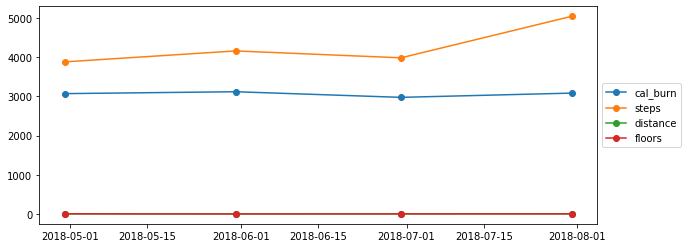

In [176]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['cal_burn','steps','distance','floors']], marker='o')
plt.legend(['cal_burn', 'steps','distance','floors'],loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xticks(["2018-0","2018-11","2018-10","2018-09","2018-08"],["Dec","Nov","Oct","Sept","Aug","Jul"])

plt.show()

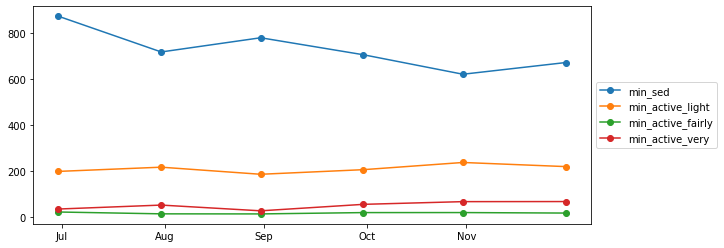

In [144]:
plt.figure(figsize=(10,4))
plt.plot(train_month.loc[:,['min_sed', 'min_active_light','min_active_fairly','min_active_very']], marker='o')
plt.legend(['min_sed','min_active_light', 'min_active_fairly', 'min_active_very'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(["2018-08","2018-09","2018-10","2018-11","2018-12"],["Jul","Aug","Sep","Oct","Nov","Dec"])

plt.show()

<div class="alert alert-block alert-warning">
<b>Answer:</b>
Armstrong has a generally sedentary lifestyle with an activity level of "light". We see a heightened steps count in Oct-Dec (colder months). He was least active in July and September, which are summer months.
</div>

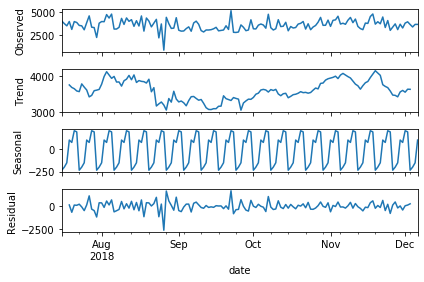

In [160]:
decomposition = sm.tsa.seasonal_decompose(train.cal_burn.resample("D").mean(), model='additive')

fig = decomposition.plot()
plt.show()

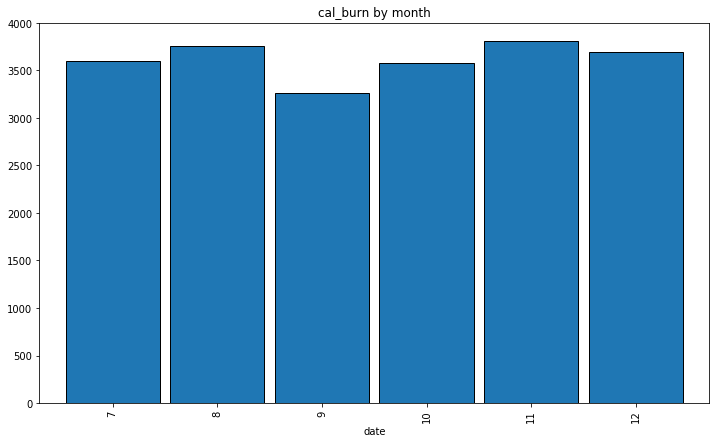

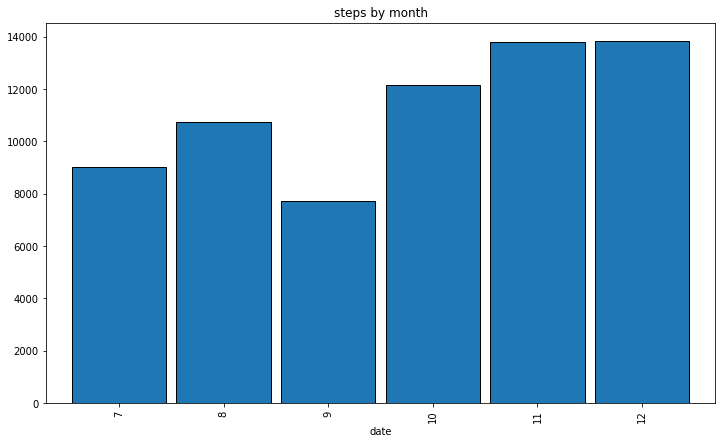

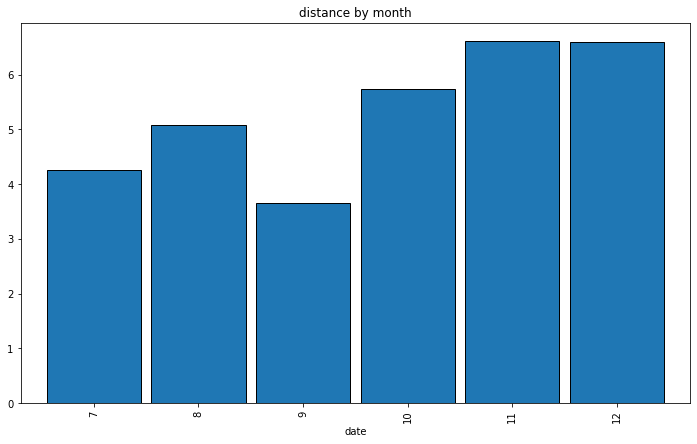

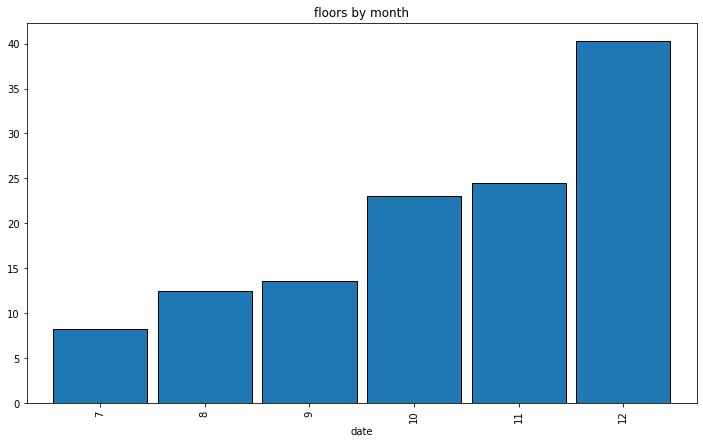

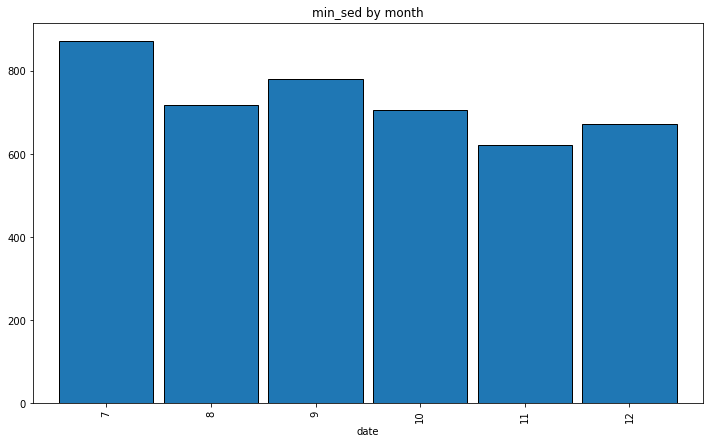

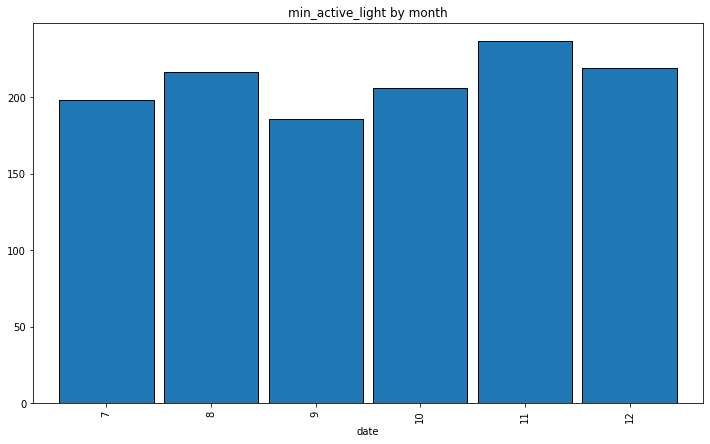

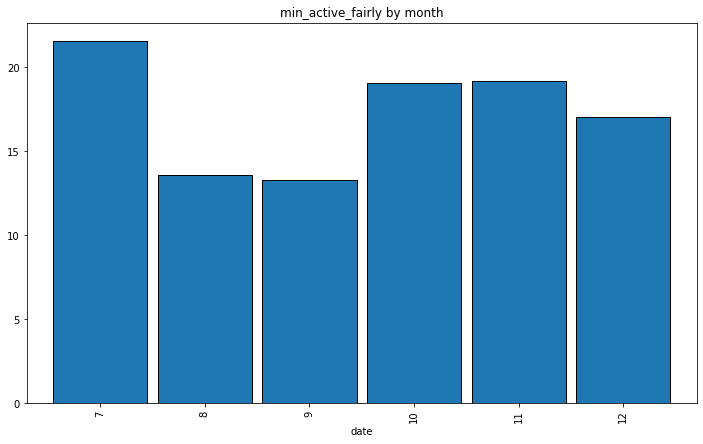

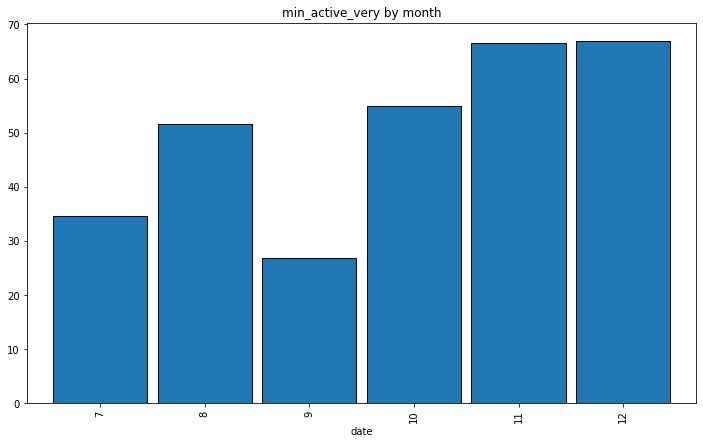

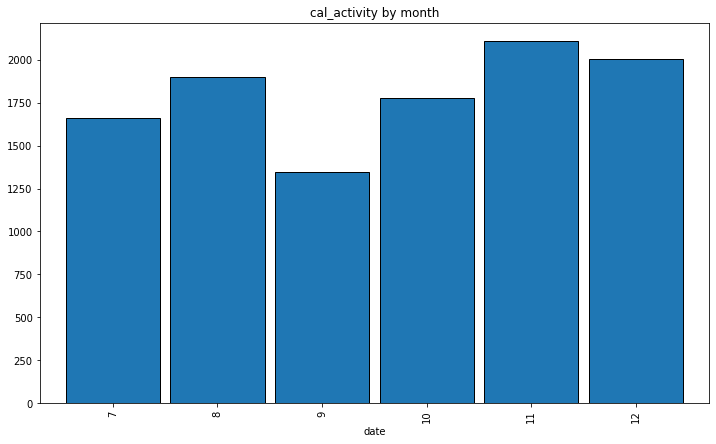

In [90]:
# sns.barplot(x=train_month.index, y="cal_burn", data=train_month, palette=["gray"]*6)

for att in train.columns:
    train.groupby(train.index.month)[att].mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
    plt.title(f"{att} by month")
    plt.show()
# flights.groupby('weekday').delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# # flights.groupby(flights.index.weekday_name).delay.mean().plot.bar(edgecolor='black', width=.9, figsize=(12, 7))
# plt.xticks(rotation=0)

## III. Model

In [ ]:
def evaluate(target_var, train = train, test = test, output=True):
    mse = metrics.mean_squared_error(test[target_var], yhat[target_var])
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse

def plot_and_eval(target_vars, train = train, test = test, metric_fmt = '{:.2f}', linewidth = 4):
    if type(target_vars) is not list:
        target_vars = [target_vars]

    plt.figure(figsize=(16, 8))
    plt.plot(train[target_vars],label='Train')
    plt.plot(test[target_vars], label='Test')

    for var in target_vars:
        mse, rmse = evaluate(target_var = var, train = train, test = test, output=False)
        plt.plot(yhat[var], linewidth=linewidth)
        print(f'{var} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse))

    plt.show()

In [ ]:
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'metric', 'value'])
eval_df

In [ ]:
# create df to store MSE & RMSE
def append_eval_df(model_type, target_vars, train = train, test = test):
    temp_eval_df = pd.concat([pd.DataFrame([[model_type, i, 'mse', evaluate(target_var = i, 
                                                                            train = train, 
                                                                            test = test, 
                                                                            output=False)[0]],
                                            [model_type, i, 'rmse', evaluate(target_var = i, 
                                                                             train = train, 
                                                                             test = test, 
                                                                             output=False)[1]]],
                                           columns=['model_type', 'target_var', 'metric', 'value']) 
                              for i in target_vars], ignore_index=True)
    return eval_df.append(temp_eval_df, ignore_index=True)

In [ ]:
periods = 30
yhat['y'] = train.y.rolling(periods).mean().iloc[-1]

# plot_and_eval(target_vars, train, test)
# eval_df = append_eval_df(model_type='moving_average', target_vars=['y'], train = train, test = test)

plt.figure(figsize=(16, 8))
plt.plot(train[target_vars],label='Train')
plt.plot(test[target_vars], label='Test')
period_vals = [1, 4, 12, 26, 52, 104]
for p in period_vals:
    yhat['y'] = train.y.rolling(p).mean().iloc[-1]
    plt.plot(yhat.y)
    print('\nrolling averge period:',p)
    print('\nitem sales\n')
    evaluate('y', train = train, test = test)